In [2]:
#!/home/neil.lu/.conda/envs/ringdown/bin/python
# coding: utf-8

import matplotlib.pyplot as pl
import numpy as np
import re
import qnm_filter
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps
import scipy as sp
import argparse
from natsort import natsorted
import glob
import astropy.units as u
import time
import os
import sys
import matplotlib
mplparams = {
    'text.usetex': True,
    'axes.linewidth': 1,
    'axes.grid': False,
    'axes.labelweight': 'normal',
    'font.family': 'DejaVu Sans',
    'font.size': 26,
    'figure.figsize': (10,8),
    'legend.fontsize':20,
    'legend.handlelength':2
}
matplotlib.rcParams.update(mplparams)

In [3]:
red = '#D60606'
blue = '#0083DE'
green = '#00BA75'
yellow = '#FFC61E'
purple = '#A433B3'
orange = '#FD882E'
color_arr = [red, blue, green, yellow, purple, orange]

In [4]:
thresh_dict = {
    '220+200:220': 6.34,
    '220+221:220': 4.85,
    '220+210:220': 6.63,
    '220+330:220': 5.02,
    '220+440:220': 6.43,
    '220+221+200:220+221' : 5.25,
    '220+221+210:220+221' : 8.61,
    '220+221+222:220+221' : 6.17,
    '220+221+330:220+221' : 4.79,
    '220+221+440:220+221' : 5.01, 
    '220+330+331:220+330' : 6.02,
    '220+330+221:220+330' : 5.39,
    '220+330+200:220+330' : 5.13,
    '220+330+210:220+330' : 5.70,
}

In [5]:
def load_data(filename):
    likelihood_data = np.loadtxt(str(directory+filename))
    evidence = sp.special.logsumexp(likelihood_data)
    
    # Metadata
    f = open(directory+filename)
    header = f.readline()[2:]

    time_patt = r"time=(\d+\.\d+)"
    time_offset = float(re.search(time_patt, header).group(1))

    evidence_patt = r"evidence=(-\d+\.\d+)"
    evidence = float(re.search(evidence_patt, header).group(1))

    filter_patt = r"model_list=(.*?)\,"
    filter_str = re.search(filter_patt, header).group(1)

    credible_patt = r"credible=(-\d+\.\d+)"
    credible = float(re.search(credible_patt, header).group(1))

    chi_patt = r"chi_bounds=\((\d+\.\d+)_(\d+\.\d+)\)"
    chi_match = re.search(chi_patt, header)
    chi_lower = float(chi_match.group(1))
    chi_upper = float(chi_match.group(2))

    mass_patt = r"mass_bounds=\((\d+)_(\d+)\)"
    mass_match = re.search(mass_patt, header)
    mass_lower = float(mass_match.group(1))
    mass_upper = float(mass_match.group(2))

    massspace = np.linspace(mass_lower, mass_upper, likelihood_data.shape[1], endpoint=False)
    chispace = np.linspace(chi_lower, chi_upper, likelihood_data.shape[0], endpoint=False)
    mass_grid, chi_grid = np.meshgrid(massspace, chispace)
    projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, np.diff(massspace)[0], np.diff(chispace)[0])
    
    return likelihood_data, evidence, time_offset, filter_str, credible, \
            chi_lower, chi_upper, mass_lower, mass_upper, \
            massspace, chispace, mass_grid, chi_grid, projected_mass, projected_chi

In [6]:
filename = "results/0305_2mode_BFcurve.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
BF_curves = data[:-1]

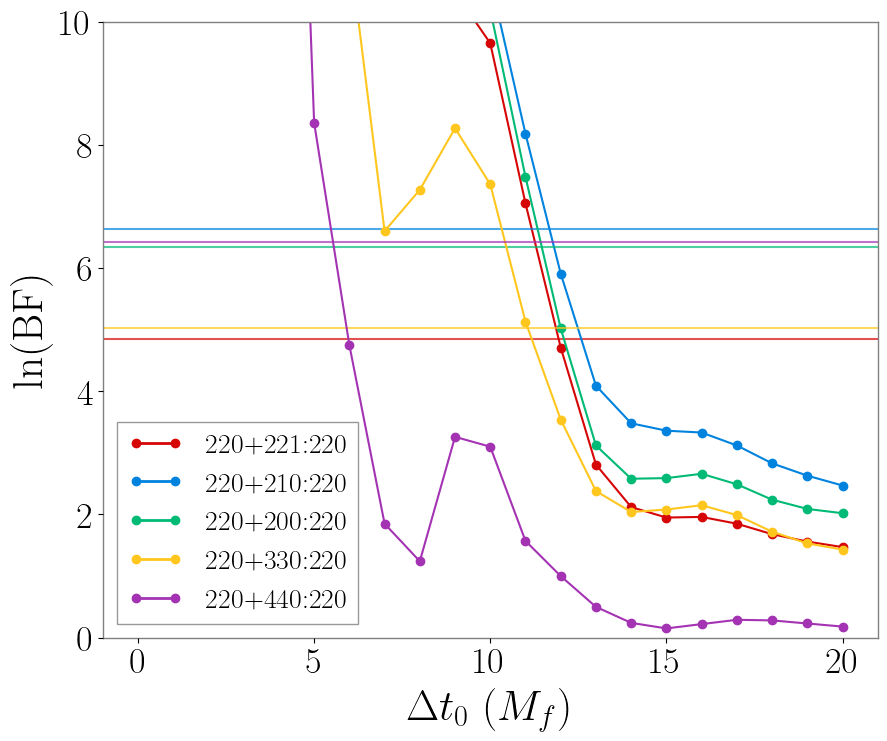

In [11]:
for idx, val in enumerate(BF_curves):
    pl.plot(time_arr, val, marker='o', label=mode_list[idx]+':220', color=color_arr[idx])
    pl.axhline(thresh_dict[mode_list[idx]+':220'],
                   alpha=0.7, color=color_arr[idx])
leg = pl.legend()
pl.ylim(0, 10)

for line in leg.get_lines():
    line.set_linewidth(2.0)
pl.xlabel(r'$\Delta t_0$ ($M_f$)')
pl.ylabel("ln(BF)")
pl.savefig("plots/SXS:0305_2mode_BF_curve.pdf")

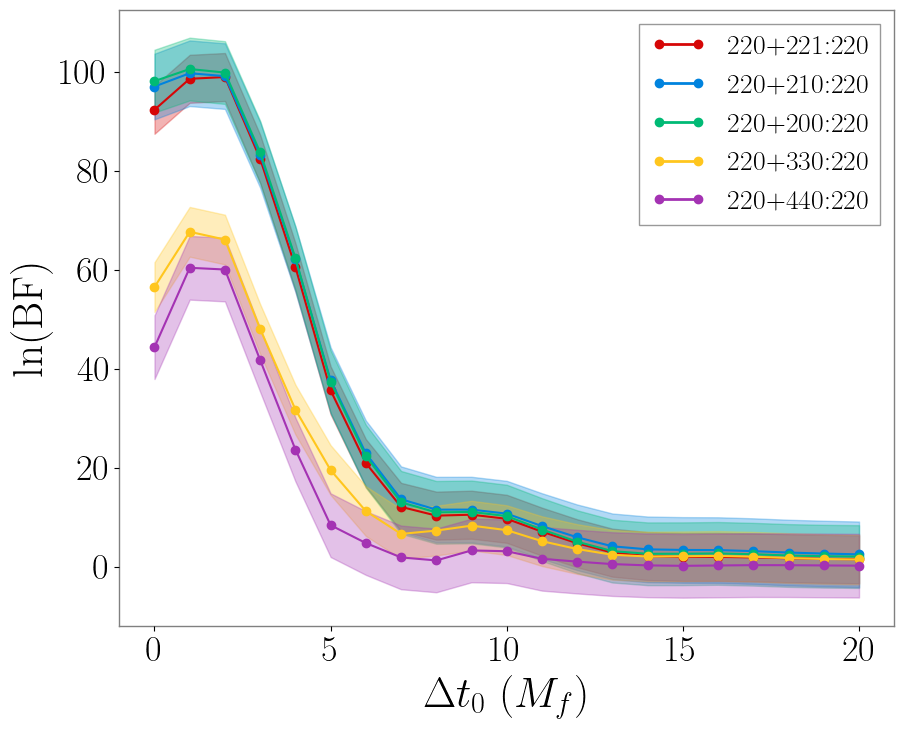

In [7]:
for idx, val in enumerate(BF_curves):
    pl.plot(time_arr, val, marker='o', label=mode_list[idx]+':220', color=color_arr[idx])
    pl.fill_between(time_arr, val-thresh_dict[mode_list[idx]+':220'], val+thresh_dict[mode_list[idx]+':220'],
                   alpha=0.3, color=color_arr[idx])
leg = pl.legend()

for line in leg.get_lines():
    line.set_linewidth(2.0)
pl.xlabel(r'$\Delta t_0$ ($M_f$)')
pl.ylabel("ln(BF)")
pl.savefig("plots/SXS:0305_2mode_BF_curve.pdf")

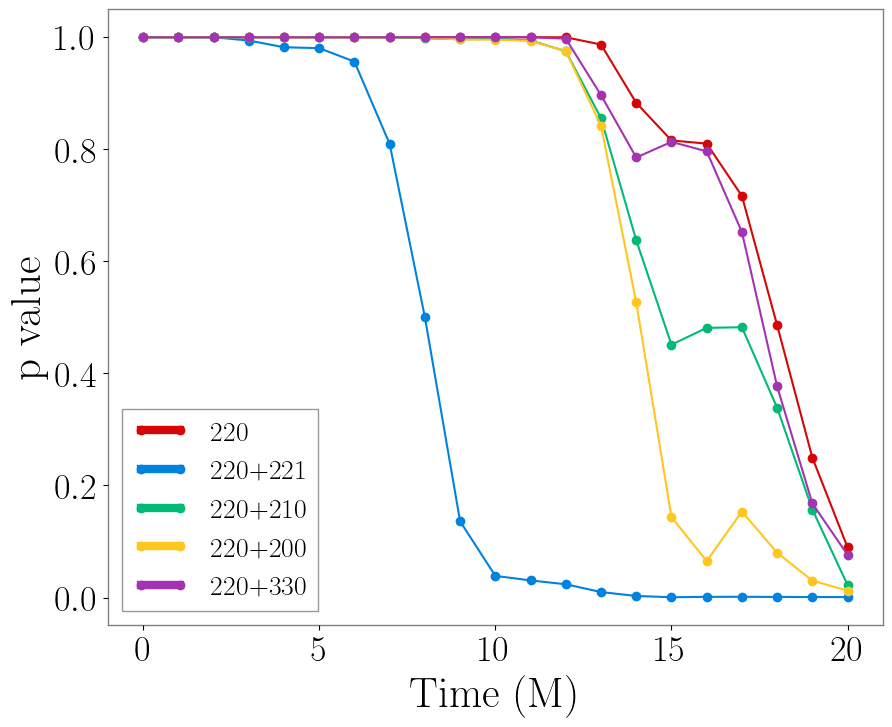

In [8]:
filename = "results/0305_2mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
pvalues = data[:-1]

for idx, val in enumerate(pvalues[:-1]):
    pl.plot(time_arr, val, marker='o', label=mode_list[idx], color=color_arr[idx])
pl.legend()
pl.xlabel("Time (M)")
pl.ylabel("p value")
pl.savefig("plots/SXS:0305_2mode_pvalue.pdf")

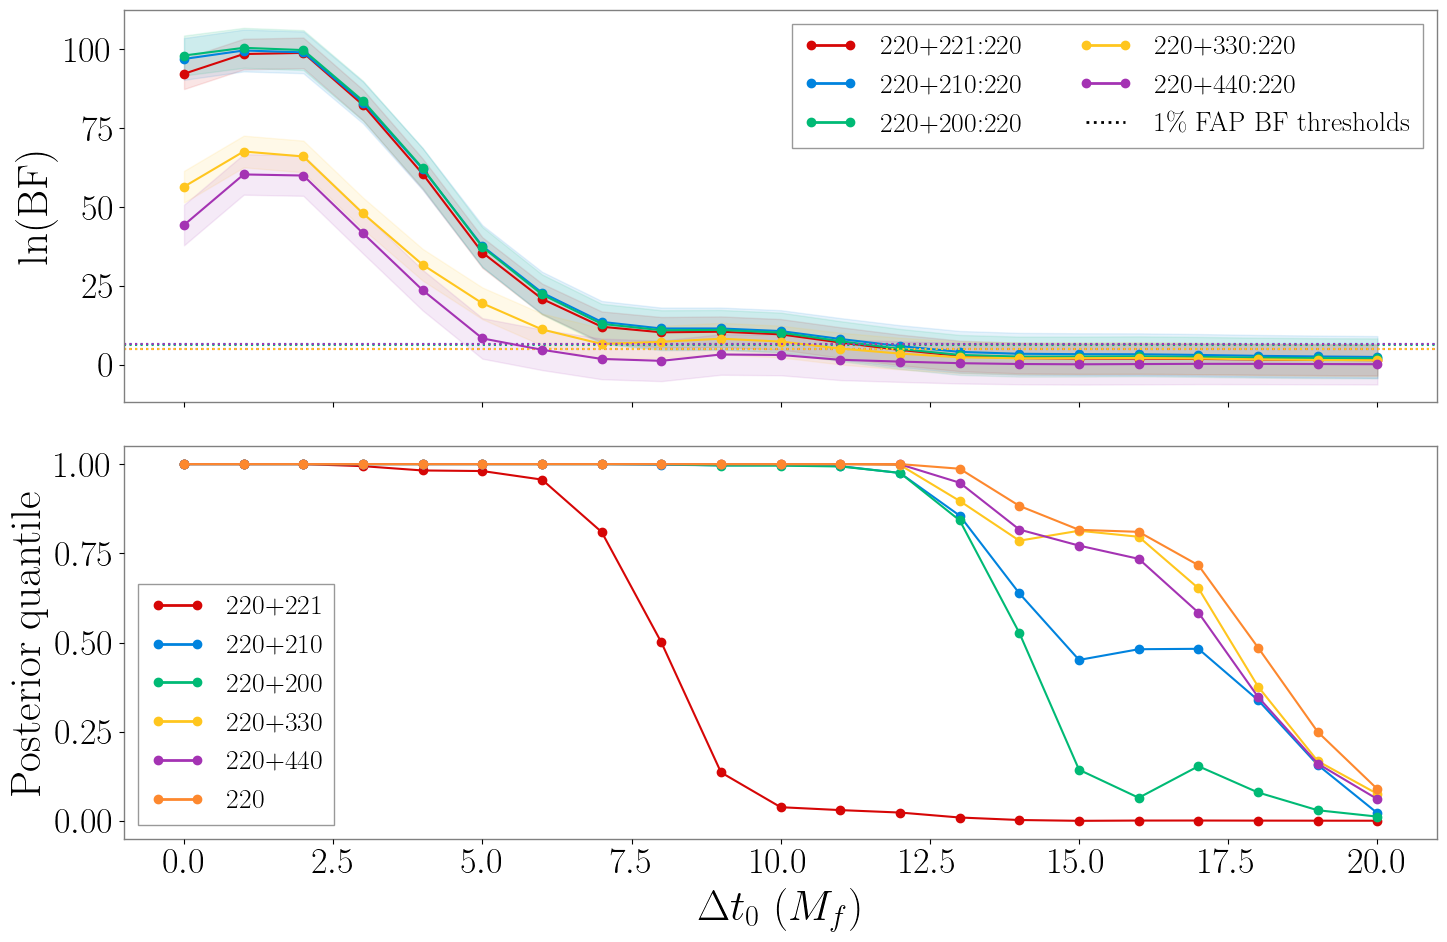

In [44]:
fig, axs = pl.subplots(2, figsize = [15, 10], sharex = True)
filename = "results/0305_2mode_BFcurve.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
BF_curves = data[:-1]
for idx, val in enumerate(BF_curves):
    axs[0].plot(time_arr, val, marker='o', label=mode_list[idx]+':220', color=color_arr[idx])
    axs[0].fill_between(time_arr, val-thresh_dict[mode_list[idx]+':220'], val+thresh_dict[mode_list[idx]+':220'],
                   alpha=0.1, color=color_arr[idx])
    axs[0].axhline(thresh_dict[mode_list[idx]+':220'],
                   alpha=1.0, color=color_arr[idx], ls=':')

axs[0].plot(np.nan, np.nan, ls=':', color = 'k', label='1\% FAP BF thresholds')
leg = axs[0].legend(ncols=2)
for line in leg.get_lines():
    line.set_linewidth(2.0)
    
axs[0].set_ylabel("ln(BF)")

filename = "results/0305_2mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

temp = {}
for idx, mode in enumerate(mode_list):
    temp[mode] = data[idx]
plotting = ["220+221", "220+210", "220+200", "220+330", "220+440", "220"]

time_arr = data[-1]
pvalues = data[:-1]
for idx, mode in enumerate(plotting):
    axs[1].plot(time_arr, temp[mode], marker='o', label=mode, color=color_arr[idx])
leg = axs[1].legend()
for line in leg.get_lines():
    line.set_linewidth(2.0)
axs[1].set_xlabel(r'$\Delta t_0$ ($M_f$)')
axs[1].set_ylabel("Posterior quantile")

pl.tight_layout()
pl.savefig("plots/0305_2mode_results.png")
pl.savefig("plots/0305_2mode_results.pdf")

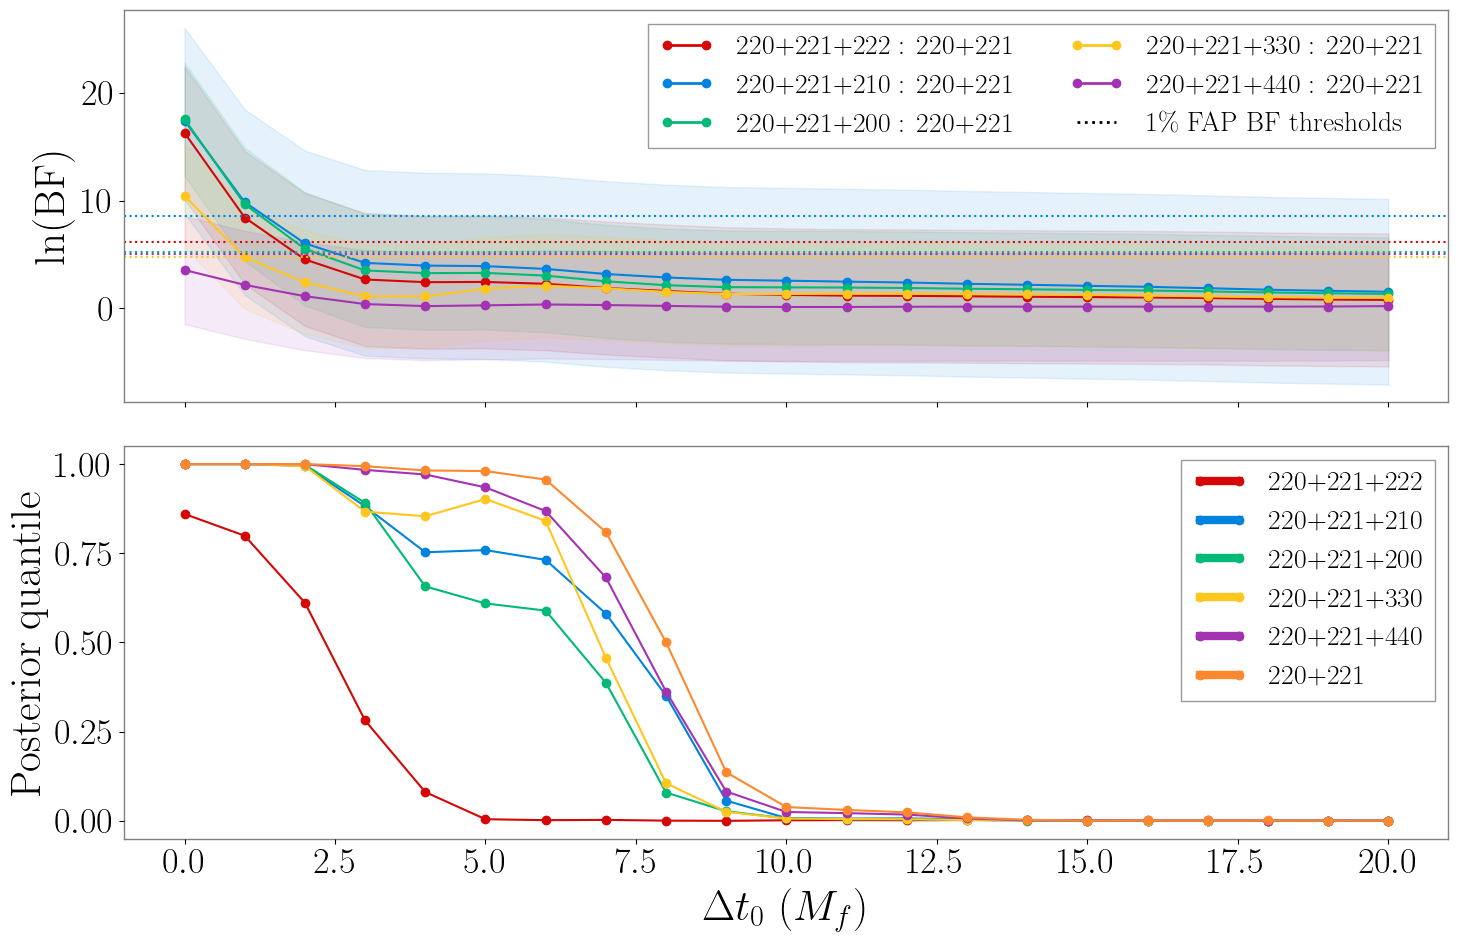

In [45]:
fig, axs = pl.subplots(2, figsize = [15, 10], sharex = True)
filename = "results/0305_3mode_BFcurve.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
BF_curves = data[:-1]
for idx, val in enumerate(BF_curves):
    axs[0].plot(time_arr, val, marker='o', label=mode_list[idx]+" : 220+221", c=color_arr[idx])
    axs[0].fill_between(time_arr, val-thresh_dict[mode_list[idx]+':220+221'], val+thresh_dict[mode_list[idx]+':220+221'],
                   alpha=0.1, color=color_arr[idx])
    axs[0].axhline(thresh_dict[mode_list[idx]+':220+221'],
                   alpha=1.0, color=color_arr[idx], ls=':')

axs[0].plot(np.nan, np.nan, ls=':', color = 'k', label='1\% FAP BF thresholds')
leg = axs[0].legend(ncols=2)
for line in leg.get_lines():
    line.set_linewidth(2.0)
    
axs[0].set_ylabel("ln(BF)")

filename = "results/0305_3mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
pvalues = data[:-1]
for idx, val in enumerate(pvalues):
    axs[1].plot(time_arr, val, marker='o', label=mode_list[idx], c=color_arr[idx])
# leg = axs[1].legend()
for line in leg.get_lines():
    line.set_linewidth(2.0)
leg = axs[1].legend()
axs[1].set_xlabel(r'$\Delta t_0$ ($M_f$)')
axs[1].set_ylabel("Posterior quantile")

pl.tight_layout()
pl.savefig("plots/0305_3mode_results.pdf")
pl.savefig("plots/0305_3mode_results.png")

## 1107

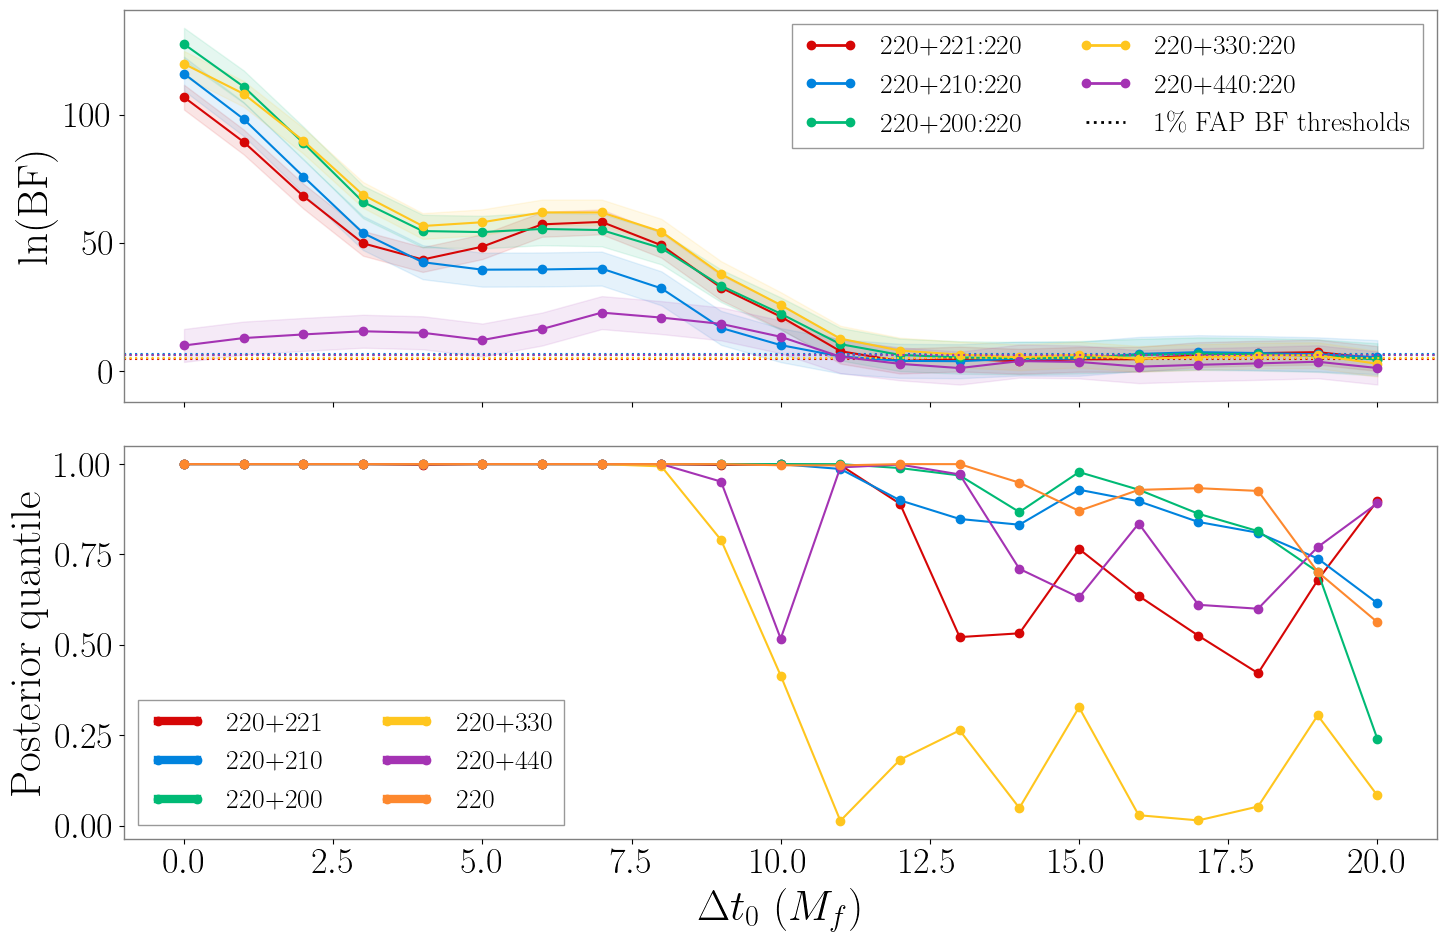

In [46]:
fig, axs = pl.subplots(2, figsize = [15, 10], sharex = True)
filename = "results/1107_2mode_BFcurve.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
BF_curves = data[:-1]
for idx, val in enumerate(BF_curves):
    axs[0].plot(time_arr, val, marker='o', label=mode_list[idx]+':220', color=color_arr[idx])
    axs[0].fill_between(time_arr, val-thresh_dict[mode_list[idx]+':220'], val+thresh_dict[mode_list[idx]+':220'],
                   alpha=0.1, color=color_arr[idx])
    axs[0].axhline(thresh_dict[mode_list[idx]+':220'],
                   alpha=1.0, color=color_arr[idx], ls=':')

axs[0].plot(np.nan, np.nan, ls=':', color = 'k', label='1\% FAP BF thresholds')
leg = axs[0].legend(ncols=2)
for line in leg.get_lines():
    line.set_linewidth(2.0)
    
axs[0].set_ylabel("ln(BF)")

filename = "results/1107_2mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
pvalues = data[:-1]
for idx, val in enumerate(pvalues):
    axs[1].plot(time_arr, val, marker='o', label=mode_list[idx], color=color_arr[idx])
# leg = axs[1].legend()
for line in leg.get_lines():
    line.set_linewidth(2.0)
axs[1].set_xlabel(r'$\Delta t_0$ ($M_f$)')
axs[1].set_ylabel("Posterior quantile")
axs[1].legend(ncols=2, loc='lower left')

pl.tight_layout()
pl.savefig("plots/1107_2mode_results.pdf")
pl.savefig("plots/1107_2mode_results.png")

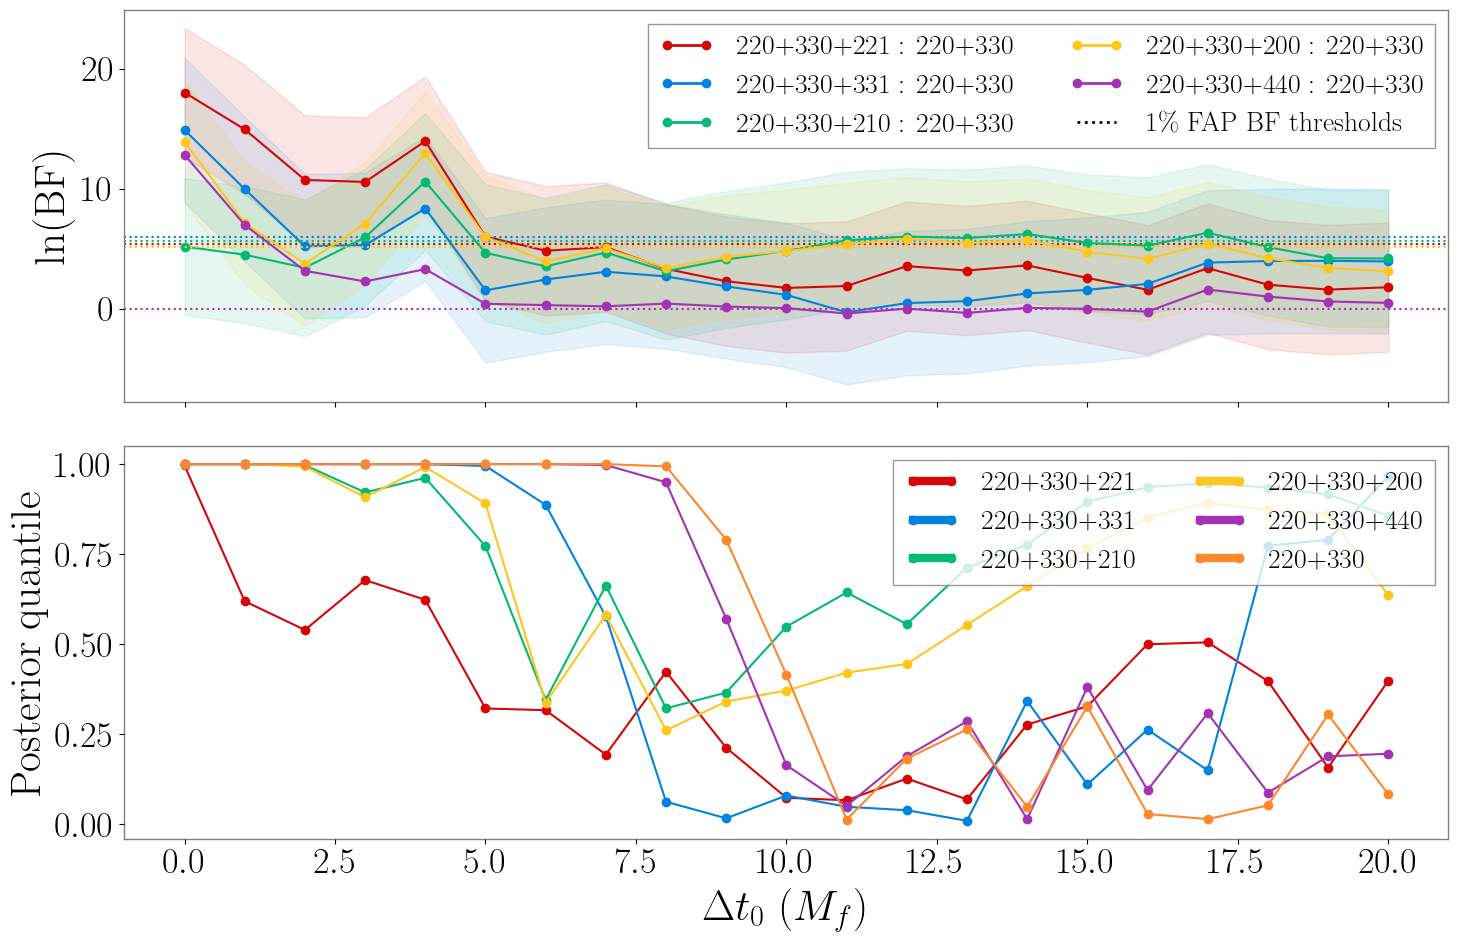

In [47]:
fig, axs = pl.subplots(2, figsize = [15, 10], sharex = True)
filename = "results/1107_3mode_BFcurve.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))
ref_mode = '220+330'

time_arr = data[-1]
BF_curves = data[:-1]
for idx, val in enumerate(BF_curves):
    axs[0].plot(time_arr, val, marker='o', label=mode_list[idx]+' : '+ref_mode, color=color_arr[idx])
    error_bar = thresh_dict.get(mode_list[idx]+':'+ref_mode, 0)
    axs[0].fill_between(time_arr, val-error_bar, val+error_bar,
                   alpha=0.1, color=color_arr[idx])
    axs[0].axhline(error_bar,
                   alpha=1.0, color=color_arr[idx], ls=':')

axs[0].plot(np.nan, np.nan, ls=':', color = 'k', label='1\% FAP BF thresholds')
leg = axs[0].legend(ncols=2)
for line in leg.get_lines():
    line.set_linewidth(2.0)
    
axs[0].set_ylabel("ln(BF)")

filename = "results/1107_3mode_pvalue.txt"
data = np.loadtxt(filename)
f = open(filename)
header = f.readline()[2:]
mode_list = eval(re.match(r"(\[.*?\])", header).group(1))

time_arr = data[-1]
pvalues = data[:-1]
for idx, val in enumerate(pvalues):
    axs[1].plot(time_arr, val, marker='o', label=mode_list[idx], color=color_arr[idx])
# leg = axs[1].legend()
for line in leg.get_lines():
    line.set_linewidth(2.0)
axs[1].set_xlabel(r'$\Delta t_0$ ($M_f$)')
axs[1].set_ylabel("Posterior quantile")
axs[1].legend(ncols=2, loc='upper right')

pl.tight_layout()
pl.savefig("plots/1107_3mode_results.pdf")
pl.savefig("plots/1107_3mode_results.png")